In [1]:
import os
import glob
from pathlib import Path
import polars as pl
import re
import gzip
import sys
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from lxml import etree, objectify
from rapidfuzz import fuzz
from spacy import displacy

import infineac.file_loader as file_loader
import infineac.helper as helper
import infineac.process_event as process_event
import infineac.topic_extractor as topic_extractor
import infineac.process_text as process_text

%load_ext autoreload
%autoreload 2

PATH_DIR = "../data/transcripts/"
random.seed(111)

/Users/Foal/miniconda3/envs/infineac/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/Foal/miniconda3/envs/infineac/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/Foal/miniconda3/envs/infineac/lib/python3.10/site-packages/

## Load NLP model

In [2]:
import spacy_stanza
nlp_stanza = spacy_stanza.load_pipeline("en", processors="tokenize, lemma")
nlp_stanza.add_pipe('sentencizer')

2023-08-31 09:50:32 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-08-31 09:50:35 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| lemma     | combined |

2023-08-31 09:50:35 WARNING: GPU requested, but is not available!
2023-08-31 09:50:35 INFO: Using device: cpu
2023-08-31 09:50:35 INFO: Loading: tokenize
2023-08-31 09:50:35 INFO: Loading: lemma
2023-08-31 09:50:35 INFO: Done loading processors!


## Load Files

Load all xml files from the given directory and return a list of corresponding events.

In [3]:
# files = [Path("../data/transcripts/2022/15203138_T.xml")]
files = list(Path(PATH_DIR).rglob("*.xml"))
events = file_loader.load_files_from_xml(files)

Files: 100%|██████████| 58613/58613 [02:30<00:00, 389.22it/s]


Check if all positions are valid

In [4]:
process_event.test_positions(events)

## Filter data

Filter out all events that are not in the given time range and do not include the given keywords.

In [5]:
events_filt_all = process_event.filter_events(events, year = 2022, keywords = {"russia":1, "ukraine":1}, modifier_words=[])
events_filt = process_event.filter_events(events, year = 2022, keywords = {"russia":1, "ukraine":1})
len(events_filt)

Filtering events


Events: 100%|██████████| 58613/58613 [00:24<00:00, 2438.82it/s]


Filtering events


Events: 100%|██████████| 58613/58613 [04:07<00:00, 236.38it/s]


11865

In [6]:
helper.save_data(events_filt, "events_filt", compression="lz4")

List all events, that are filtered out due to modifier words preceding the keywords.

In [8]:
events_filtered_filter_words = []
ids_filtered_events = []
for i, event in enumerate(events_filt):
    ids_filtered_events.append(event['id'])
for event in events_filt_all:
    if event['id'] not in ids_filtered_events:
        events_filtered_filter_words.append(event)
print(len(events_filtered_filter_words))
process_event.extract_passages_from_events(events_filtered_filter_words, keywords=["russia", "ukraine"], modifier_words=[], nlp_model=nlp_stanza)

6
Extracting paragraphs from events


Events: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]


[[[[[' In addition, there will still be significant opportunity for expansion beyond this as these 70-plus countries represent less than 60% of broadband homes globally, excluding Russia and China.']]],
  []],
 [[],
  [[[' Now we finally have begun that journey with the Finaro acquisition, and there will be others in order to support what I think is one of the best justifications for international expansion possible, which is the subscription billing sexy tech platform that has opportunities literally in every part of the world, except Russia and China.']]]],
 [[],
  [[['So you see that there is no change on our guidance either for H1, 6% to 8%, excluding Russia, of full year. We confirm the 6% to 8% growth, excluding Russia.']],
   [['And the performance of the division was 7% like-for-like, excluding Russia.']]]],
 [[[['European growth would have been 7% on a year-to-date basis in local currency, excluding Russia.']]],
  []],
 [[[['International revenues were up 11% or 14% excluding 

## Exploration

In [9]:
file = [event['file'] for event in events_filt]
id = [event['id'] for event in events_filt]
year_upload = [event['year_upload'] for event in events_filt]
company = [event['company_name'] for event in events_filt]
ticker = [event['company_ticker'] for event in events_filt]
ticker_new = [re.sub('\\..*', '', t) for t in ticker]
dates = [event['date'] for event in events_filt if "date" in event.keys()]
numeric_values = mdates.date2num(dates)

russia_and_sanction = [process_text.get_russia_and_sanction(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
election = [process_text.get_elections(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
russia_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('russia') for event in events_filt]
sanction_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('sanction') for event in events_filt]

Create a DataFrame with the following columns:

In [10]:
df = pd.DataFrame({'file': file,
                   'year_upload': year_upload,
                   'company': company,
                   'ticker':ticker,
                   'ticker_new': ticker_new,
                   'date': dates,
                   'dates_num' : numeric_values,
                   'russia': russia_and_sanction,
                   'russia_count': russia_count,
                   'sanction_count': sanction_count,
                   'election': election})

Count the number of occasions where the word "russia" (and "sanction") appears in the earnings call.

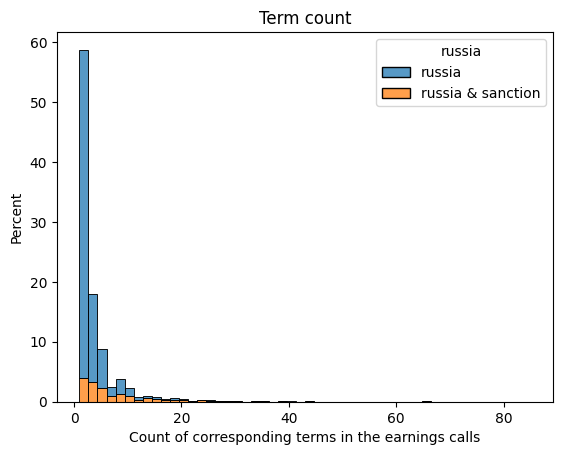

In [11]:
sns.histplot(df[df['russia_count']>=1], x='russia_count', hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
plt.xlabel('Count of corresponding terms in the earnings calls')
plt.ylabel('Percent')
plt.title('Term count')
plt.show()

Average mentions of "russia" per earnings call.

In [12]:
np.array(russia_count).mean()

2.7451327433628316

Average mentions of "russia" per earnings call if "russia" is mentioned at
least once.

In [13]:
np.array([el for el in russia_count if el > 0]).mean()

3.8724289620734753

Average mentions of "sanction" per earnings call.

In [14]:
np.array([el for el in sanction_count if el > 0]).mean()

2.4227877385772123

Event distribution over time highlighting the different categories.

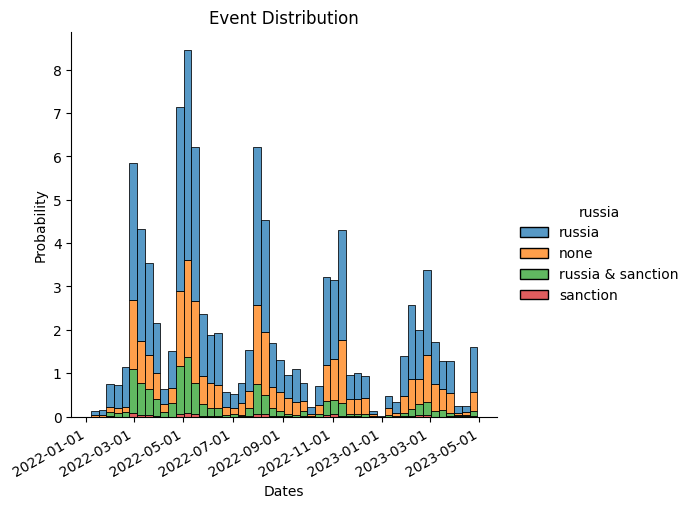

In [15]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Probability')
plt.title('Event Distribution')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

Event proportion over time highlighting the different categories.

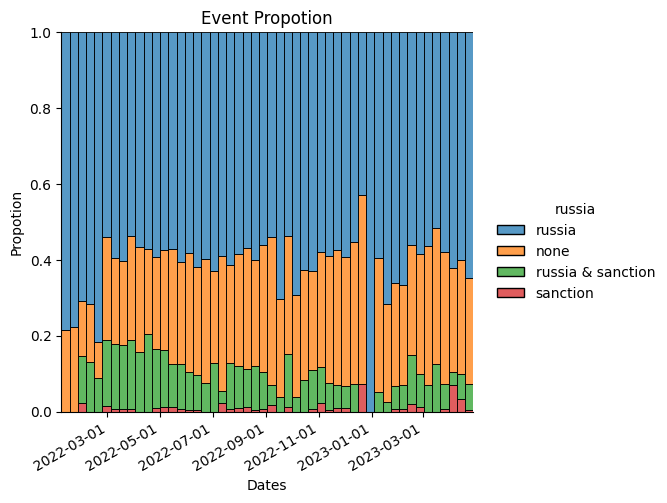

In [16]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="proportion", common_norm=True, multiple="fill")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Propotion')
plt.title('Event Propotion')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

## Preprocess and extract corpus

In [4]:
events_filt = helper.load_data("events_filt.lz4")

Create different types of corpora:
1. Corpus with a window of 1 sentence and not joining adjacent sentences.
2. Corpus with a window of 1 sentence and joining adjacent sentences.
3. Corpus with a window of 3 sentences and joining adjacent sentences.
4. Corpus with a window of 5 sentences and joining adjacent sentences.
5. Corpus with a window that includes the whole paragraph from the keywords on.

In [5]:
corpus_window_0_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=False,
    extract_answers=True,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_0_df)

Extracting passages from events


Events: 100%|██████████| 11865/11865 [20:36<00:00,  9.59it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 45646/45646 [24:10<00:00, 31.47it/s]  


45646

In [6]:
corpus_window_0_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=True,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_0_join_df)

Extracting passages from events


Events: 100%|██████████| 11865/11865 [24:24<00:00,  8.10it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 40946/40946 [19:54<00:00, 34.28it/s] 


40946

In [7]:
corpus_window_3_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=[0,3],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=True,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_3_join_df)

Extracting passages from events


Events: 100%|██████████| 11865/11865 [22:48<00:00,  8.67it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 38933/38933 [26:35<00:00, 24.40it/s]  


38933

In [8]:
corpus_window_5_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=[0,5],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=True,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_5_join_df)

Extracting passages from events


Events: 100%|██████████| 11865/11865 [25:47<00:00,  7.67it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 38646/38646 [26:22<00:00, 24.41it/s] 


38646

In [9]:
corpus_window_whole_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords={"russia": 1, "ukraine": 1},
    context_window_sentence=[0,-1],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=True,
    nlp_model=nlp_stanza,
    remove_additional_words=True,
)
len(corpus_window_whole_join_df)

Extracting passages from events


Events: 100%|██████████| 11865/11865 [29:50<00:00,  6.63it/s] 


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 38868/38868 [28:44<00:00, 22.53it/s] 


38868

In [10]:
helper.save_data(corpus_window_0_df, "corpus_window_0_df", compression="lz4")
helper.save_data(corpus_window_0_join_df, "corpus_window_0_join_df", compression="lz4")
helper.save_data(corpus_window_3_join_df, "corpus_window_3_join_df", compression="lz4")
helper.save_data(corpus_window_5_join_df, "corpus_window_5_join_df", compression="lz4")
helper.save_data(corpus_window_whole_join_df, "corpus_window_whole_join_df", compression="lz4")

In [ ]:
corpus_window_0_df = helper.load_data("corpus_window_0_df.lz4")
corpus_window_0_join_df = helper.load_data("corpus_window_0_join_df.lz4")
corpus_window_3_join_df = helper.load_data("corpus_window_3_join_df.lz4")
corpus_window_5_join_df = helper.load_data("corpus_window_5_join_df.lz4")
corpus_window_whole_join_df = helper.load_data("corpus_window_whole_join_df.lz4")

In [31]:
lengths = [len(doc) for doc in corpus_window_0_df['processed_text'].to_list()]
np.argmax(np.array(lengths))

4893

### Analyse corpus

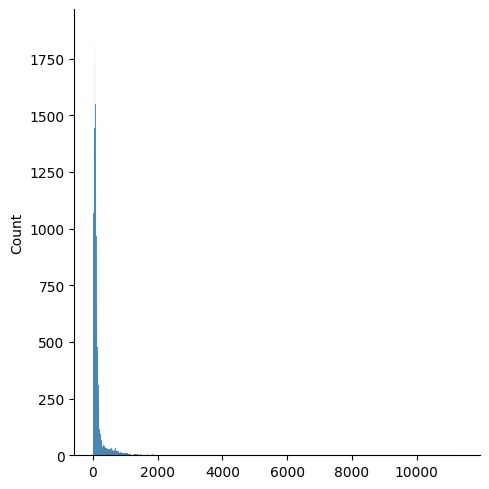

In [32]:
sns.displot(np.array(lengths))

## Extract topics

1.
* Sentence window: 0
* No join

In [11]:
topic_model_0, topics_0, probs_0 = topic_extractor.bert_inspired(corpus_window_0_df['processed_text'].to_list())

Batches:   0%|          | 0/1427 [00:00<?, ?it/s]

2023-08-31 14:38:14,090 - BERTopic - Transformed documents to Embeddings
2023-08-31 14:39:05,833 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-08-31 14:44:21,784 - BERTopic - Clustered reduced embeddings


In [22]:
topic_model_0.get_topic_info().to_csv("topic_model_0.csv")

2.
* Sentence window: 0
* Join sentences

In [12]:
topic_model_0_join, topics_0_join, probs_0_join = topic_extractor.bert_inspired(corpus_window_0_join_df['processed_text'].to_list())

Batches:   0%|          | 0/1280 [00:00<?, ?it/s]

2023-08-31 14:48:55,084 - BERTopic - Transformed documents to Embeddings
2023-08-31 14:49:19,987 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-08-31 14:52:08,108 - BERTopic - Clustered reduced embeddings


In [23]:
topic_model_0_join.get_topic_info().to_csv("topic_model_0_join.csv")

3.
* Sentence window: 3
* Join sentences  

In [13]:
topic_model_3_join, topics_3_join, probs_3_join = topic_extractor.bert_inspired(corpus_window_3_join_df['processed_text'].to_list())

Batches:   0%|          | 0/1217 [00:00<?, ?it/s]

2023-08-31 14:57:49,883 - BERTopic - Transformed documents to Embeddings
2023-08-31 14:58:12,559 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-08-31 15:00:00,899 - BERTopic - Clustered reduced embeddings


In [21]:
topic_model_3_join.get_topic_info().to_csv("topic_model_3_join.csv")

4.
* Sentence window: 5
* Join sentences


In [14]:
topic_model_5_join, topics_5_join, probs_5_join = topic_extractor.bert_inspired(corpus_window_5_join_df['processed_text'].to_list())

Batches:   0%|          | 0/1208 [00:00<?, ?it/s]

2023-08-31 15:06:31,375 - BERTopic - Transformed documents to Embeddings
2023-08-31 15:06:51,024 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-08-31 15:09:00,223 - BERTopic - Clustered reduced embeddings


In [24]:
topic_model_5_join.get_topic_info().to_csv("topic_model_5_join.csv")

5.
* Sentence window: whole paragraph
* Join sentences

In [15]:
topic_model_whole_join, topics_whole_join, probs_whole_join = topic_extractor.bert_inspired(corpus_window_whole_join_df['processed_text'].to_list())

Batches:   0%|          | 0/1215 [00:00<?, ?it/s]

2023-08-31 15:15:23,146 - BERTopic - Transformed documents to Embeddings
2023-08-31 15:15:42,651 - BERTopic - Reduced dimensionality


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2023-08-31 15:17:37,673 - BERTopic - Clustered reduced embeddings


In [25]:
topic_model_whole_join.get_topic_info().to_csv("topic_model_whole_join.csv")

38868

In [356]:
probs[1]

array([0.02466603, 0.032443  , 0.0426969 , 0.02744634, 0.02321597,
       0.0192848 , 0.0492035 , 0.01937474, 0.04401463, 0.04043768,
       0.04437236, 0.02610516, 0.02285282, 0.02287447, 0.0305101 ])

In [49]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,19059,-1_inflation_crisis_pandemic_economic,"[inflation, crisis, pandemic, economic, demand...",[market forecast market base current visibilit...
1,0,4650,0_demand_market_business_guidance,"[demand, market, business, guidance, portfolio...",[yes typically provide update midway quarter o...
2,1,820,1_refugee_humanitarian_charity_donation,"[refugee, humanitarian, charity, donation, uni...","[support people refugee, support refugee emplo..."
3,2,660,2_belarus_belarusian_kazakhstan_russian,"[belarus, belarusian, kazakhstan, russian, cou...","[sale belarus, year go belarus, belarus]"
4,3,535,3_wheat_corn_agriculture_agricultural,"[wheat, corn, agriculture, agricultural, grain...","[corn wheat come big way, know difficulty asso..."
...,...,...,...,...,...
301,300,10,300_revenue_growth_year_offset,"[revenue, growth, year, offset, contractual, t...",[emea year year growth quarter negatively affe...
302,301,10,301_freight_turnover_rail_railway,"[freight, turnover, rail, railway, railroad, t...",[look month year freight rail turnover overall...
303,302,10,302_expect_expectation_demand_profitability,"[expect, expectation, demand, profitability, f...",[yes start contract manufacturing know get gen...
304,303,10,303_decline_maintenance_service_growth,"[decline, maintenance, service, growth, offsho...",[service growth america menac strong oil gas o...


In [358]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(corpus_window_0_join_df['processed_text'].to_list(), calculate_tokens=True)

100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


In [359]:
len(topic_distr)

933

In [363]:
topic_distr[1]

array([0.27688306, 0.        , 0.        , 0.        , 0.15484435,
       0.15860631, 0.32902648, 0.        , 0.        , 0.08063981,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [361]:
# topic distribution of a certain document
topic_model.visualize_distribution(topic_distr[1])

In [365]:
# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(corpus_window_0_join_df['processed_text'].to_list()[1], topic_token_distr[1])
df

,conversely,get,europe,north,america,look,geopolitical,risk,particularly,associate,go,look,maybe,derisk,global,basis,move,little,bit,close,headquarters,operation
0_demand_production_industry_market,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.235,0.365,0.365,0.259,0.130,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4_macroeconomic_inflation_inflationary_economy,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.102,0.102,0.102,0.204,0.102,0.102,0.102,0.000,0.000,0.000,0.000
5_revenue_business_profit_investment,0.000,0.000,0.000,0.000,0.000,0.000,0.101,0.209,0.209,0.209,0.108,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6_energy_demand_heating_war,0.000,0.115,0.223,0.223,0.223,0.108,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.105,0.211,0.211,0.211,0.106,0.000,0.000
9_grain_foodtech_harvest_soybean,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.106,0.106,0.106,0.000,0.000


In [372]:
# values for individual topics
topic_model.get_topic(1)

[('refinery', 0.48095948),
 ('refiner', 0.4155772),
 ('import', 0.4111076),
 ('oil', 0.3860207),
 ('europe', 0.3736658),
 ('diesel', 0.36351082),
 ('fuel', 0.35027352),
 ('eu', 0.3479474),
 ('supply', 0.34047055),
 ('russian', 0.33826613)]

In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder

In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-distilroberta-base-v1')
sentence1 = "Now this slide talks more about the immediate impact where the combination of sanctions and also business destruction in Ukraine leads or may lead to supply chain disruptions."
sentence2 = "We obviously intensively evaluate all the potential impacts, created a task force that meets almost daily to follow on these topics and basically do preventive measures as to limit the potential impact on CEZ."

doc1 = nlp(sentence1)
doc2 = nlp(sentence2)
similarity = doc1.similarity(doc2)

sentences_ = [sentence1, sentence2]
sentence_embeddings = model.encode(sentences_)

print("Cosine Similarity: " + str(util.pytorch_cos_sim(sentence_embeddings[0], sentence_embeddings[1]).item()))
print("similiarity: " + str(similarity))

In [ ]:
# import dill as pickle
# pickle.dump(events_russia, open('../output/pickled/events_russia.pkl', 'wb'))
# pickle.dump(events, open('../output/pickled/events.pkl', 'wb'))

In [ ]:
docs = [event['presentation_collapsed'] + "\n" + event['qa_collapsed'] for event in events_russia]

In [ ]:
df.to_csv('../output/data/overview.csv', index=False)

In [ ]:
#  df[['company', 'ticker', 'ticker_new', 'date', 'russia', 'russia_count', 'sanction_count']].to_csv('../output/data/overview_jakob.csv', index=False)
# with open('../output/data/overview_jakob.csv', 'rb') as f_in:
#     with gzip.open('../output/data/overview_jakob.csv.gz', 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

Create 15 samples for each category: russia and election and save it in the
corresponding directory.

In [ ]:
if len(df[df['russia'] == 'russia & sanctions']) >0:sample_files_russia = df[df['russia'] == 'russia'].sample(8)['file'].tolist() + df[df['russia'] == 'russia & sanctions'].sample(7)['file'].tolist()
if len(df[df['election'] == 'presidential election']) >0: sample_files_election = df[df['election'] == 'presidential election'].sample(15)['file'].tolist()

In [ ]:
# delete all files in folder
if 'sample_files_russia' in locals() or 'sample_files_russia' in globals():
    folder = '../output/sample transcripts/russia/'
    files = os.listdir(folder)
    for f in files:
        os.remove(folder + f)
    # copy sample files to folder
    for file in sample_files_russia:
        shutil.copy(file, folder)

In [ ]:
# delete all files in folder
if 'sample_files_election' in locals() or sample_files_election in globals():
    folder = '../output/sample transcripts/election/'
    files = os.listdir(folder)
    for f in files:
        os.remove(folder + f)
    # copy sample files to folder
    for file in sample_files_election:
        shutil.copy(file, folder)

Polars

In [ ]:
keys_to_keep = ['file', 'body_orig']

In [ ]:
events_new_trimmed = [{key: event[key] for key in keys_to_keep} for event in events_new]

In [ ]:
eventsDF = pl.from_dicts(events_new_trimmed)

In [ ]:
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(E|e)lections').alias("elections_count"))
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(S|s)anctions').alias("sanctions_count"))
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(R|r)ussia').alias("russia_count"))

In [ ]:
len(eventsDF.filter(pl.col("elections_count") > 0))

In [ ]:
len(eventsDF.filter((pl.col("sanctions_count") > 0) & (pl.col("russia_count") > 0)))